<a href="https://colab.research.google.com/github/askewai/ML_challenge/blob/main/d7-weatherForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### data source: (https://catalog.data.gov/dataset/local-weather-archive)
### initial format: csv

The dataset, titled "Local Weather Archive," contains historical weather data for Raleigh Durham International Airport, sourced from the NOAA Climate Data Online web service. It has been converted to commonly used units and serves as an archive, meaning it is no longer being updated. Published by the National Oceanic and Atmospheric Administration (NOAA) - National Centers for Environmental Information (NCEI), the dataset was last modified on February 14, 2016, and is publicly accessible under the CC0 1.0 Universal license. It falls under the "Environment" category and is available in English. Metadata was created on November 12, 2020, and last updated on October 19, 2024.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score

In [21]:
df = pd.read_csv('/content/weather.csv', sep=';', parse_dates=['date'])
df = df.sort_values('date')

# EDA

In [22]:
df.head(10)

,date,tmin,tmax,prcp,snow,snwd,awnd
816,2017-01-01,41,50,0.54,0.0,0.0,6.49
421,2017-01-02,47,51,1.08,0.0,0.0,5.59
0,2017-01-03,47,56,0.31,0.0,0.0,5.37
1607,2017-01-04,41,64,0.00,0.0,0.0,5.82
422,2017-01-05,29,44,0.00,0.0,0.0,2.01
423,2017-01-06,32,43,0.25,0.0,0.0,6.04
1,2017-01-07,20,32,0.60,0.5,0.0,9.62
817,2017-01-08,15,27,0.00,0.0,1.2,4.92
1223,2017-01-09,9,31,0.00,0.0,1.2,2.46
2,2017-01-10,24,48,0.00,0.0,1.2,5.14


In [23]:
df.nunique()

,0
date,1977
tmin,69
tmax,75
prcp,152
snow,14
snwd,7
awnd,117


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1977 entries, 816 to 1976
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1977 non-null   datetime64[ns]
 1   tmin    1977 non-null   int64         
 2   tmax    1977 non-null   int64         
 3   prcp    1977 non-null   float64       
 4   snow    1977 non-null   float64       
 5   snwd    1976 non-null   float64       
 6   awnd    1973 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 123.6 KB


In [25]:
df.describe()

,date,tmin,tmax,prcp,snow,snwd,awnd
count,1977,1977.000000,1977.000000,1977.000000,1977.000000,1976.000000,1973.000000
mean,2019-09-16 00:00:00,51.088012,72.298938,0.135771,0.012838,0.016953,6.074805
min,2017-01-01 00:00:00,4.000000,27.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-05-10 00:00:00,37.000000,60.000000,0.000000,0.000000,0.000000,3.800000
50%,2019-09-16 00:00:00,52.000000,74.000000,0.000000,0.000000,0.000000,5.800000
75%,2021-01-22 00:00:00,66.000000,86.000000,0.060000,0.000000,0.000000,7.800000
max,2022-05-31 00:00:00,78.000000,102.000000,4.960000,7.000000,5.900000,20.360000
std,NaN,15.889527,15.796087,0.370521,0.227433,0.215338,2.954427


In [26]:
df.isnull().sum()

,0
date,0
tmin,0
tmax,0
prcp,0
snow,0
snwd,1
awnd,4


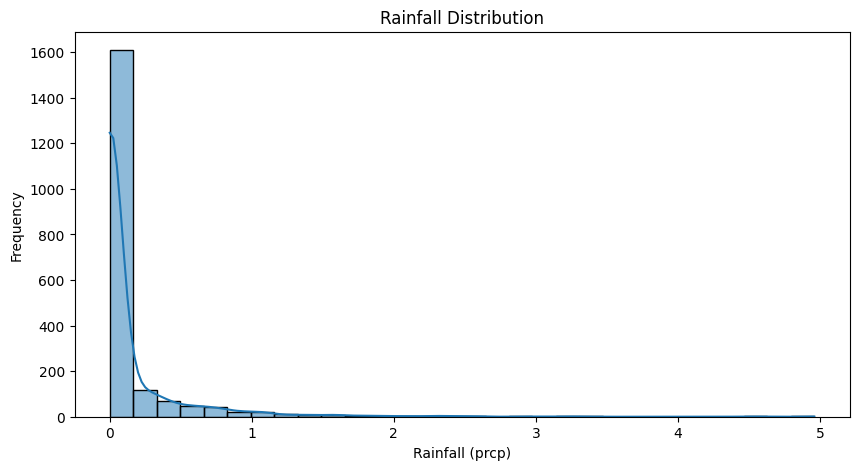

In [27]:
plt.figure(figsize=(10,5))
sns.histplot(df['prcp'], bins=30, kde=True)
plt.title("Rainfall Distribution")
plt.xlabel("Rainfall (prcp)")
plt.ylabel("Frequency")
plt.show()

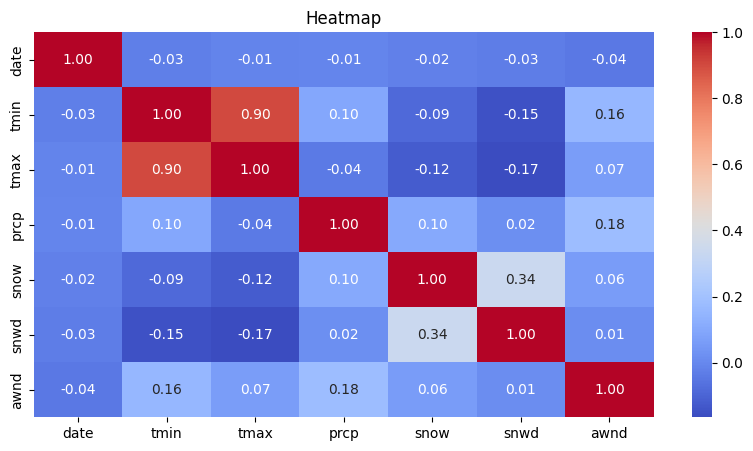

In [28]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap")
plt.show()

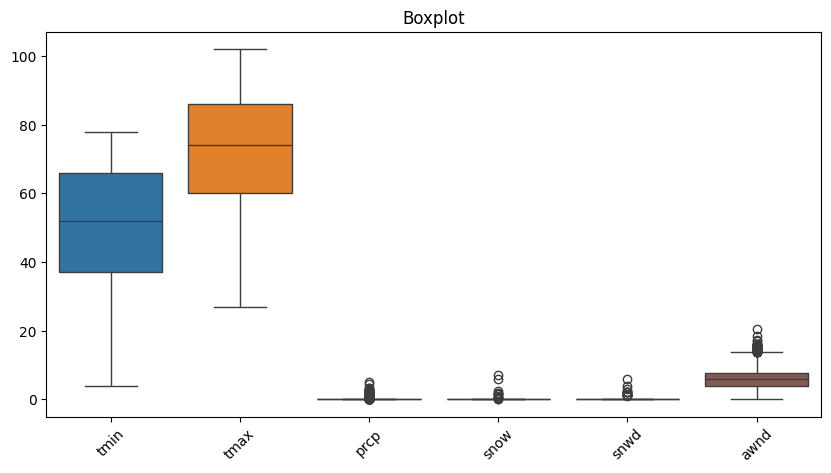

In [29]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['tmin', 'tmax', 'prcp', 'snow', 'snwd', 'awnd']])
plt.title("Boxplot")
plt.xticks(rotation=45)
plt.show()

In [30]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [31]:
df['prcp_next'] = df['prcp'].shift(-1)  #Target
df['rain_next'] = (df['prcp_next'] > 0).astype(int)

<ipython-input-31-6fb2ed3b70b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prcp_next'] = df['prcp'].shift(-1)  #Target
<ipython-input-31-6fb2ed3b70b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rain_next'] = (df['prcp_next'] > 0).astype(int)


In [32]:
df.dropna(inplace=True)

<ipython-input-32-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


preprocessing

In [33]:
features = ['tmin', 'tmax', 'prcp', 'snow', 'snwd', 'awnd']
X = df[features]
y_reg = df['prcp_next']  # Target untuk regresi
y_class = df['rain_next']  # Target untuk klasifikasi

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
pca = PCA(n_components=3)  # Mengurangi dimensi menjadi 3 komponen utama
X_pca = pca.fit_transform(X_scaled)

In [36]:
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_cls, X_test_cls, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

modelling

In [37]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_reg_train)
y_reg_pred = reg_model.predict(X_test)
mse = mean_squared_error(y_reg_test, y_reg_pred)
print(f'MSE (Regression): {mse:.4f}')

MSE (Regression): 0.0007


In [38]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_cls, y_class_train)
    y_class_pred = model.predict(X_test_cls)
    accuracy = accuracy_score(y_class_test, y_class_pred)
    print(f'Accuracy ({name}): {accuracy:.4f}')

Accuracy (Random Forest): 0.8103
Accuracy (Gradient Boosting): 0.8264
Accuracy (SVM): 0.8392
Accuracy (KNN): 0.8006
Accuracy (XGBoost): 0.8199


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:29:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


before i this score, i got 0.60 average. but when i applied handling outliers, standard scaler, and PCA, it is better.

In [39]:
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio per PCA Component:", explained_variance)

Explained Variance Ratio per PCA Component: [0.49212602 0.27152724 0.21717853]
